# Çekişmeli Üretici Ağlar (Generative Adversarial Networks) (GAN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU # Relu varyasyonudur pozitif değerler için aynen değeri aktarırken negatif değerleri çok küçük bir katsayı ile çarpar 
from tensorflow.keras.layers import Dense , Reshape , Flatten , Conv2D ,Conv2DTranspose , BatchNormalization
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm # For döngüsüne ilerleme sayacı ekleme işlemi .

import warnings 
warnings.filterwarnings("ignore")

### 1)Veri Setinin Yüklenmesi 

In [2]:
# mnist veri setini yukle
(x_train, _ ), ( _, _ ) = mnist.load_data() # sadece training yukle


Normalizasyon İşlemi

In [3]:
# normalizasyon
x_train = x_train / 255.0

Boyutların ayarlanması ( 28 , 28 ) => ( 28 , 28 , 1 )

In [4]:
# boyutlarin ayarlanmasi (28x28) -> (28,28,1)
x_train = np.expand_dims(x_train, axis=-1)

In [5]:
x_train.shape

(60000, 28, 28, 1)

### 2)Modelerin Oluşturulması

Discriminator Modelin Oluşturulması

In [6]:
# gan parametreleri
z_dim = 100 # gurultu vektorunun boyutu

# discriminator modeline tanimla
def build_discriminator():
    
    model = Sequential()
    # Conv2D: 64 filtre, 3x3 cekirdek (kernel), stride = 2, padding = same, activation= LeakyRelu
    model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = "same", input_shape = (28,28,1)))
    model.add(LeakyReLU(alpha = 0.2))
    # Conv2D: 128 filtre, 3x3 cekirdek (kernel), stride = 2, padding = same, activation= LeakyRelu
    model.add(Conv2D(128, kernel_size=3, strides = 2, padding="same"))
    model.add(LeakyReLU(alpha = 0.2))
    # flatten -> output layer
    model.add(Flatten()) # goruntuyu tek boyutlu vektore donusturur
    model.add(Dense(1, activation = "sigmoid")) # output layer 
    # compile 
    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5), metrics = ["accuracy"])
    
    return model

Generator Modelinin Oluşturulması

In [7]:
# generator modelini tanimla
def build_generator():
    
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=z_dim)) # gurultu vektorlerinden yuksek boyutlu uzaya donusum
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((7,7,128))) # cikisi (7x7x128) olacak sekilde ayarliyoruz
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, kernel_size=3, strides = 2, padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, kernel_size = 3, strides = 2, padding = "same", activation = "tanh"))
    
    return model
    

### 3)GAN Modeli Oluşturma

In [8]:
# gan modeli olusturma
def build_gan(generator, discriminator):
    
    discriminator.trainable = False # discriminator egitilemez
    
    model = Sequential()
    model.add(generator) # gan yapisina ilk olarak generator ekliyoruz
    model.add(discriminator) # gan yapisina discriminator ekle
    model.compile(loss="binary_crossentropy", optimizer = Adam(0.0002, 0.5))
    
    return model

In [9]:
discriminator = build_discriminator() # discriminator modeli olustur
generator = build_generator() # generator modelini olustur 
gan = build_gan(generator, discriminator) # gan modeli olustur

In [10]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 28, 28, 1)           │         708,609 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │          80,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,378 (3.01 MB)

 Trainable params: 708,225 (2.70 MB)

 Non-trainable params: 81,153 (317.00 KB)

### 4)Gan Model Eğitimi

In [11]:
epochs = 1000
batch_size = 64
half_batch = batch_size // 2

# Egitim Dongusu
for epoch in tqdm(range(epochs), desc = "Training Process"): # tqdm ile ilerleme cubugu eklenir.
    
    # gercek veriler ile discriminator egitimi yapilacak
    idx = np.random.randint(0, x_train.shape[0], half_batch) # x_train icerisinden rastgele 32 adet veri sec
    real_images = x_train[idx] # gercek goruntuler
    real_labels = np.ones((half_batch, 1)) # gercek etiketler = 1
    
    # fake verileri (generator'in urettigi) ile discriminator egitimi
    noise = np.random.normal(0, 1, (half_batch, z_dim)) # gurultu vektorleri
    fake_images = generator.predict(noise, verbose = 0) # uretilen goruntuler
    fake_labels = np.zeros((half_batch, 1)) # sahte etiketler = 0 
    
    # update discriminator
    d_loss_real = discriminator.train_on_batch(real_images, real_labels) # gercek verilerle kayip hesaplama
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels) # sahte verilerle kayip hesaplama
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5 # ortalama kayip
    
    # train gan
    noise = np.random.normal(0, 1, (batch_size, z_dim)) # gurultu vektorleri
    valid_y = np.ones((batch_size, 1)) # dogru etiketler
    g_loss = gan.train_on_batch(noise, valid_y) # gan'in icinde bulunan generator training
        
    if epoch % 100 == 0:
        print(f"\n{epoch}/{epochs} D loss: {d_loss[0]}, G loss: {g_loss}")
        


Training Process:   0%|▏                                                              | 3/1000 [00:01<08:51,  1.88it/s]


0/1000 D loss: 0.6943665742874146, G loss: 0.6887946128845215


Training Process:  10%|██████▏                                                      | 102/1000 [00:10<01:10, 12.70it/s]


100/1000 D loss: 0.7131843566894531, G loss: 0.4818270802497864


Training Process:  20%|████████████▎                                                | 202/1000 [00:19<01:05, 12.27it/s]


200/1000 D loss: 0.7606890201568604, G loss: 0.37383344769477844


Training Process:  30%|██████████████████▍                                          | 302/1000 [00:27<00:56, 12.44it/s]


300/1000 D loss: 0.8437566757202148, G loss: 0.31527769565582275


Training Process:  40%|████████████████████████▌                                    | 402/1000 [00:35<00:48, 12.46it/s]


400/1000 D loss: 0.9321706891059875, G loss: 0.27956634759902954


Training Process:  50%|██████████████████████████████▌                              | 502/1000 [00:43<00:38, 12.91it/s]


500/1000 D loss: 1.0031787157058716, G loss: 0.25561556220054626


Training Process:  60%|████████████████████████████████████▋                        | 602/1000 [00:51<00:31, 12.57it/s]


600/1000 D loss: 1.0565268993377686, G loss: 0.23843063414096832


Training Process:  70%|██████████████████████████████████████████▊                  | 702/1000 [00:59<00:23, 12.45it/s]


700/1000 D loss: 1.097217082977295, G loss: 0.2254767268896103


Training Process:  80%|████████████████████████████████████████████████▉            | 802/1000 [01:07<00:16, 11.98it/s]


800/1000 D loss: 1.1289961338043213, G loss: 0.21539293229579926


Training Process:  90%|███████████████████████████████████████████████████████      | 902/1000 [01:15<00:07, 12.61it/s]


900/1000 D loss: 1.154433250427246, G loss: 0.2073386311531067


Training Process: 100%|████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.95it/s]


### 4)Üretilen Görüntülerin Karşılaştırılması 

In [12]:
def plot_genarated_images(generator , epoch , examples = 10 ,dim = (1,10) ):
    noise = np.random.normal(0,1,( examples , z_dim )) #Gürültü Vektörleri
    gen_images = generator.predict( noise , verbose = 0 ) # Üretilen gürültüler 
    gen_images = 0.5 * gen_images + 0.5 
    plt.figure(figsize = (10,1))
    for i in range(gen_images.shape[0]):
        plt.subplot(dim[0] , dim[1] , i+1 ) # Alt Grafikler oluşturma
        plt.imshow(gen_images[i , : , : , 0] , cmap = "gray" ) # Görüntüyü gri tonlama ile gösterme 
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Üretilen görüntülerin gösterilmesi

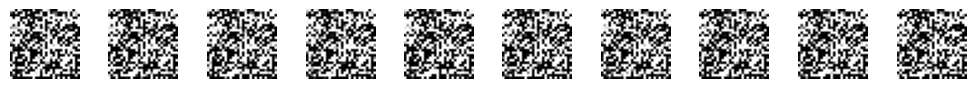

In [13]:
plot_genarated_images( generator , epochs )